# overview

### import section

In [1]:
import math
import re
import time
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from joblib import load


### preprocessing

In [2]:
# --- Preprocessing ---
# Read and preprocess data
try:
    X = pd.read_pickle("data/processed/calc_descriptors_final.pkl")
except FileNotFoundError:
    print("Error: 'data/processed/calc_descriptors_final.pkl' not found.")
    exit()

try:
    df = pd.read_pickle("data/processed/gap_smile.pkl")
except FileNotFoundError:
    print("Error: 'data/processed/gap_smile.pkl' not found.")
    exit()

scaler = MinMaxScaler()
X["Ipc"] = scaler.fit_transform(X["Ipc"].values.reshape(-1, 1))

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

y = df["GAP"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=42
)

# Load the trained model
try:
    reg = load("data/processed/reg_GBR.joblib")
except FileNotFoundError:
    print("Error: 'data/processed/reg_GBR.joblib' not found.")
    exit()

### metrics

In [3]:
# --- Metrics ---
def get_metrics(
    df: pd.DataFrame, pred_col: str, true_col: str
) -> Dict[str, float]:
    """
    Calculates regression metrics for a given DataFrame and columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        pred_col (str): The name of the column with predicted values.
        true_col (str): The name of the column with true values.

    Returns:
        dict: A dictionary containing R-squared, Mean Squared Error (MSE),
              Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).
    """
    y_pred = df[pred_col]
    y_true = df[true_col]
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    return {"R2": r2, "MSE": mse, "MAE": mae, "RMSE": rmse}


In [4]:
# Predict and evaluate
gap_pred = reg.predict(scaled_X)
df["GAP_P"] = gap_pred

# Metric analysis
print("\n--- General Analysis ---")
y_pred_train = reg.predict(X_train)
train_metrics = get_metrics(
    pd.DataFrame({"GAP_P": y_pred_train, "GAP": y_train}), "GAP_P", "GAP"
)
print("Train Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

y_pred_test = reg.predict(X_test)
test_metrics = get_metrics(
    pd.DataFrame({"GAP_P": y_pred_test, "GAP": y_test}), "GAP_P", "GAP"
)
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Concat the dataframes
print("\n--- Metrics for Subsets of Descriptors ---")
df_concat = pd.concat([df, X], axis=1, join="inner")
df_concat["diff"] = df_concat["GAP"] - df_concat["GAP_P"]


--- General Analysis ---


/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


Train Metrics:
R2: 0.9917
MSE: 0.0139
MAE: 0.0907
RMSE: 0.1177


/home/sat/miniforge3/envs/py310hl_gaps_pub/lib/python3.10/site-packages/numpy/lib/function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)



Test Metrics:
R2: 0.9562
MSE: 0.0730
MAE: 0.1867
RMSE: 0.2701

--- Metrics for Subsets of Descriptors ---


### visualize 

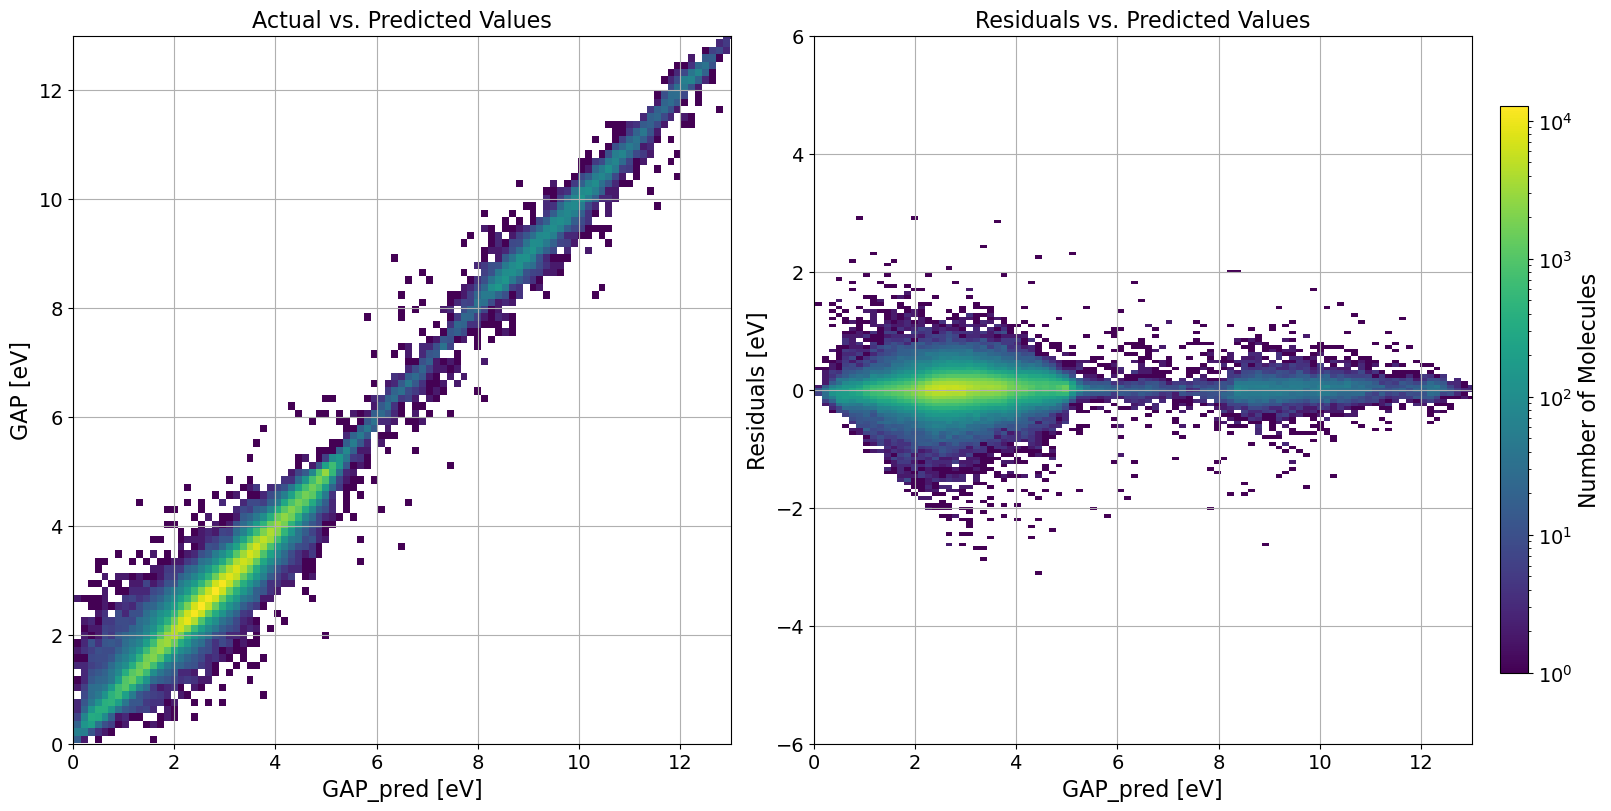

In [5]:
# Define data for the first plot
x1 = df_concat['GAP']
y1 = df_concat['GAP_P']
heatmap1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=100, density=False)

# Define data for the second plot
x2 = df_concat['GAP_P']
y2 = df_concat['diff']
heatmap2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=100, density=False)

# Determine shared color scale
vmin = min(heatmap1[heatmap1 > 0].min(), heatmap2[heatmap2 > 0].min(), 1e0)
vmax = max(heatmap1.max(), heatmap2.max())

# Create a subplot with 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# First subplot: Actual vs. Predicted
im1 = axs[0].imshow(
    heatmap1.T,
    extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    norm=LogNorm(vmin=vmin, vmax=vmax)
)
axs[0].set_xlim(0, 13)
axs[0].set_ylim(0, 13)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=14)  # Change tick label font size
axs[0].set_xlabel('GAP_pred [eV]',fontsize=16)
axs[0].set_ylabel('GAP [eV]',fontsize=16)
axs[0].set_title('Actual vs. Predicted Values',fontsize=16)

# Second subplot: Residuals vs. Predicted
im2 = axs[1].imshow(
    heatmap2.T,
    extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    norm=LogNorm(vmin=vmin, vmax=vmax)
)
axs[1].set_xlim(0, 13)
axs[1].set_ylim(-6, 6)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=14)  # Change tick label font size
axs[1].set_xlabel('GAP_pred [eV]' ,fontsize=16)
axs[1].set_ylabel('Residuals [eV]',fontsize=16)
axs[1].set_title('Residuals vs. Predicted Values',fontsize=16)

# Add a single colorbar for both plots
cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('Number of Molecules',fontsize=16)
cbar.ax.tick_params(labelsize=14)

#plt.savefig("PED_heatmap.png")
plt.show()

### feature importance

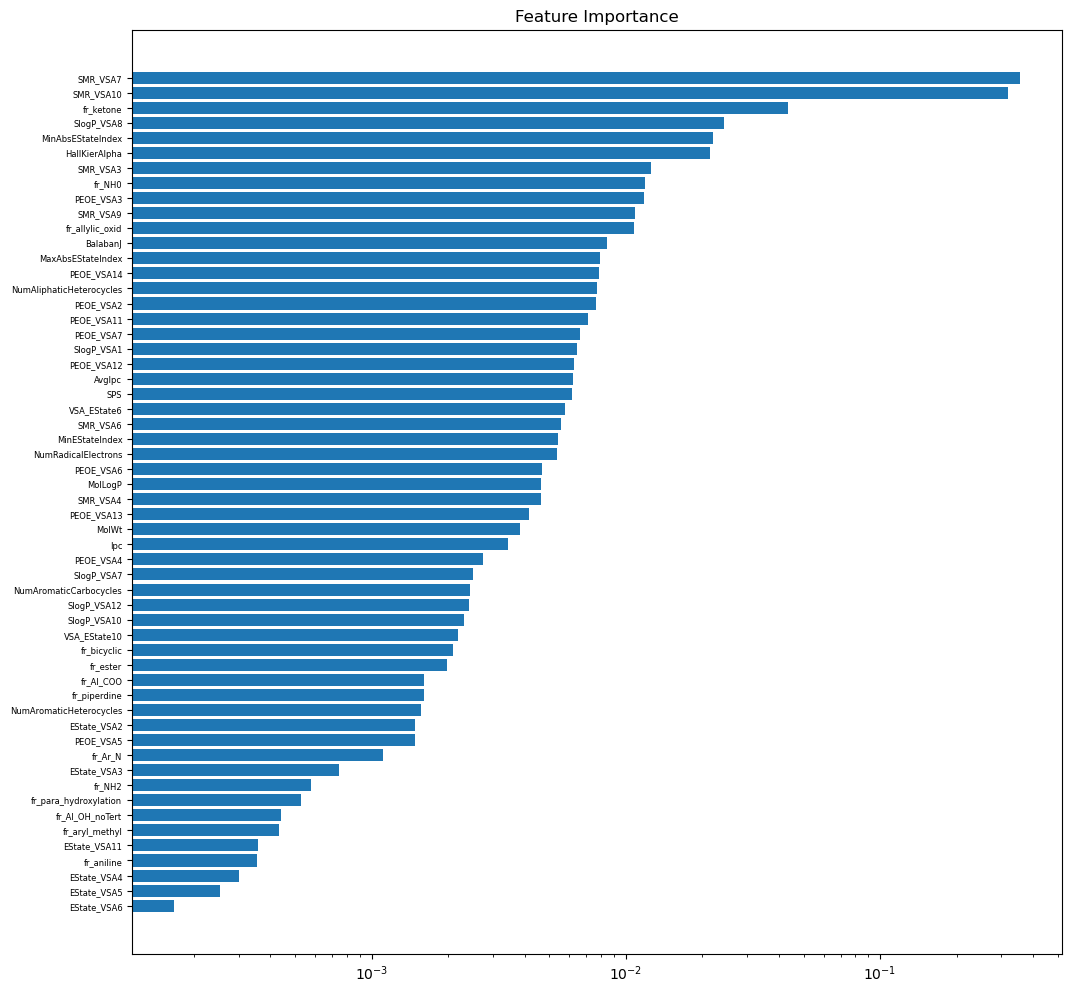

In [9]:
# --- Feature importance ---
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 12))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx], fontsize=6)
plt.xscale("log")
plt.title("Feature Importance")
plt.show()

### analyse random search GBR

In [14]:
# --- Analyze random search GBR ---
try:
    with open("data/processed/slurm-512835.out", "r") as f:
        rr = f.read().splitlines()
except FileNotFoundError:
    print("Error: 'data/processed/slurm-512835.out' not found.")
    exit()

rr = [x for x in rr if "CV" in x]
rr = [x.replace("END ", "") for x in rr]
rr = [x.replace("CV ", "CV=") for x in rr]
rr = [x.replace("[", "") for x in rr]
rr = [x.replace("]", ",") for x in rr]
rr = [x.replace("/2", "") for x in rr]
rr = [x.replace(";", "") for x in rr]
rr = [x.replace(")", "),") for x in rr]
rr = [x.replace(",,", ",") for x in rr]
rr = [x.split("=") for x in rr]

rm_list = [
    "CV",
    "learning_rate",
    "loss",
    "max_depth",
    "n_estimators",
    "subsample",
    "alpha",
    "ccp_alpha",
    "criterion",
    "init",
    "max_features",
    "max_leaf_nodes",
    "min_impurity_decrease",
    "min_samples_leaf",
    "min_samples_split",
    "min_weight_fraction_leaf",
    "n_iter_no_change",
    "random_state",
    "tol",
    "validation_fraction",
    "verbose",
    "warm_start",
    "score",
    "test",
    "train",
    "time",
    "total",
    "min",
    ",",
    "\\(",
    "\\)",
]

for nrun, run in enumerate(rr):
    for num, item in enumerate(run):
        for rm in rm_list:
            item = re.sub(rm, "", item)
        run[num] = item
    rr[nrun] = list(filter(None, run))

cols = [
    "CV",
    "learning_rate",
    "loss",
    "max_depth",
    "n_estimators",
    "subsample",
    "score_train",
    "score_test",
    "time",
]
dty = {
    "CV": np.int16,
    "learning_rate": np.float32,
    "loss": str,
    "max_depth": np.int16,
    "n_estimators": np.int16,
    "subsample": np.float32,
    "score_train": np.float32,
    "score_test": np.float32,
    "time": np.float32,
}
frame = pd.DataFrame(data=rr, columns=cols)
frame = frame.astype(dtype=dty)
frame["r2_residuals"] = frame["score_train"] - frame["score_test"]

print(len(frame) / 4)
frame.loc[frame["score_test"] >= 0.94].sort_values(
        by=["r2_residuals", "score_test"], ascending=True
    )

1000.0


,CV,learning_rate,loss,max_depth,n_estimators,subsample,score_train,score_test,time,r2_residuals
1714,1,0.024912,squared_error,8,1177,0.564491,0.964,0.940,48.400002,0.024
1932,1,0.029396,squared_error,8,1017,0.548078,0.964,0.940,40.000000,0.024
1563,1,0.036605,squared_error,8,832,0.569513,0.965,0.940,34.799999,0.025
1699,1,0.033451,squared_error,8,938,0.514217,0.965,0.940,35.099998,0.025
1782,1,0.031024,squared_error,8,1036,0.508624,0.965,0.940,38.799999,0.025
...,...,...,...,...,...,...,...,...,...,...
1621,2,0.068353,squared_error,12,1161,0.438450,0.999,0.945,53.799999,0.054
1679,2,0.066551,squared_error,12,1117,0.466011,0.999,0.945,54.900002,0.054
2599,2,0.067074,squared_error,12,1154,0.230451,0.996,0.941,26.900000,0.055
2981,1,0.069290,squared_error,12,1161,0.217216,0.996,0.941,25.200001,0.055


In [13]:
df_avg = (
    frame.drop("loss", axis=1)
    .sort_values(by="learning_rate", ascending=False)
    .groupby(np.arange(len(frame.index)) // 2)
    .mean()
)
df_avg.sort_values(by="score_test", ascending=False)

,CV,learning_rate,max_depth,n_estimators,subsample,score_train,score_test,time,r2_residuals
1486,1.5,0.032108,12.0,1171.0,0.691712,0.9960,0.9480,85.050003,0.0480
1354,1.5,0.035376,12.0,1164.0,0.624980,0.9960,0.9480,77.150002,0.0480
1283,1.5,0.037297,11.0,1181.0,0.693825,0.9940,0.9480,81.149994,0.0460
1671,1.5,0.027621,12.0,1159.0,0.584300,0.9940,0.9480,71.199997,0.0460
448,1.5,0.058616,10.0,1105.0,0.626091,0.9930,0.9475,62.750000,0.0455
...,...,...,...,...,...,...,...,...,...
1697,1.5,0.026887,8.0,929.0,0.235034,0.9530,0.9325,15.650000,0.0205
1981,1.5,0.020351,8.0,981.0,0.312612,0.9520,0.9325,21.799999,0.0195
1801,1.5,0.024428,8.0,978.0,0.220786,0.9515,0.9320,15.450001,0.0195
1849,1.5,0.023176,8.0,898.0,0.266926,0.9510,0.9320,17.200001,0.0190


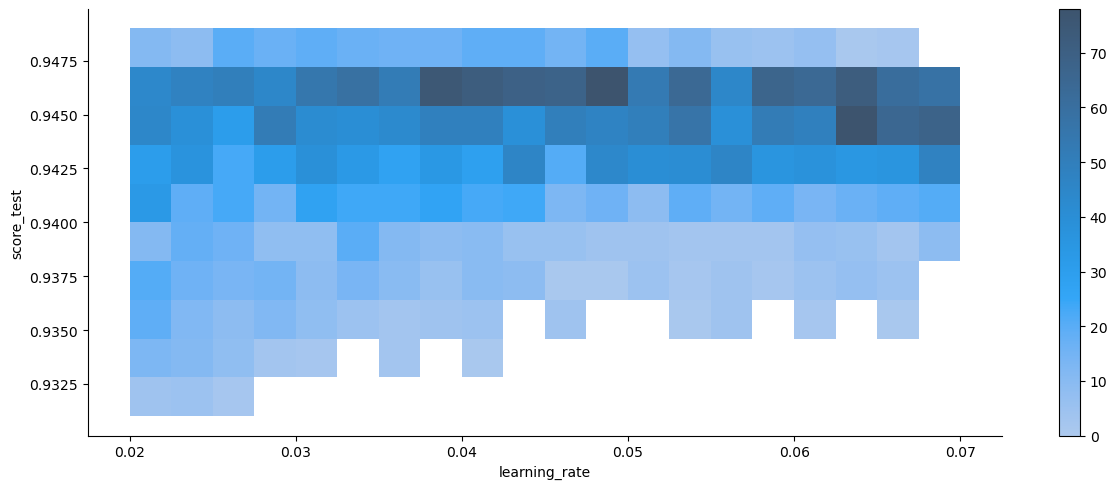

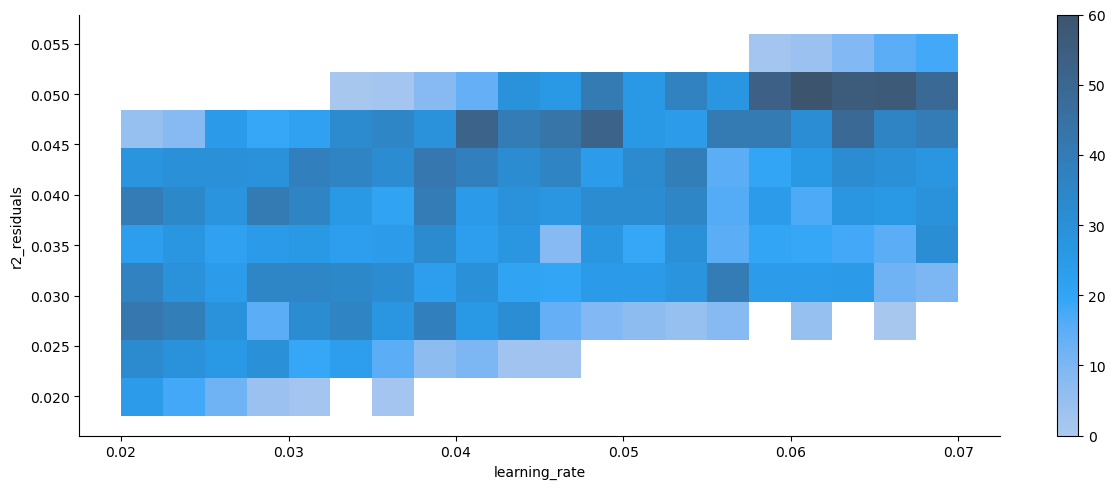

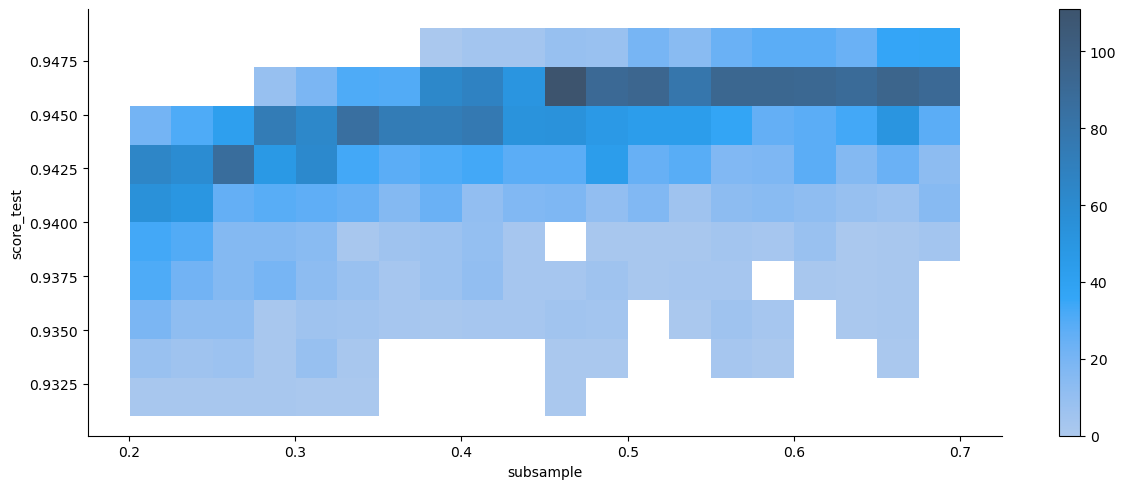

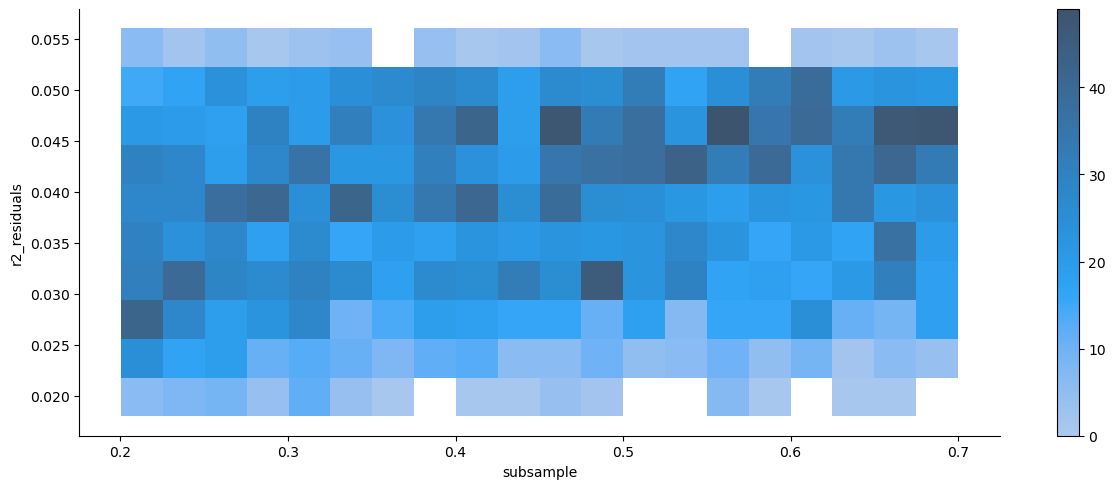

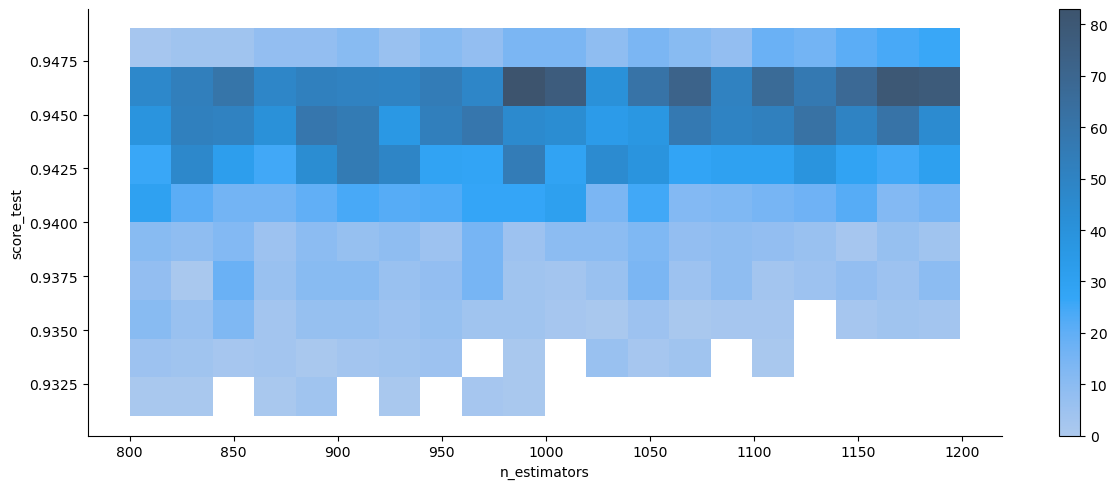

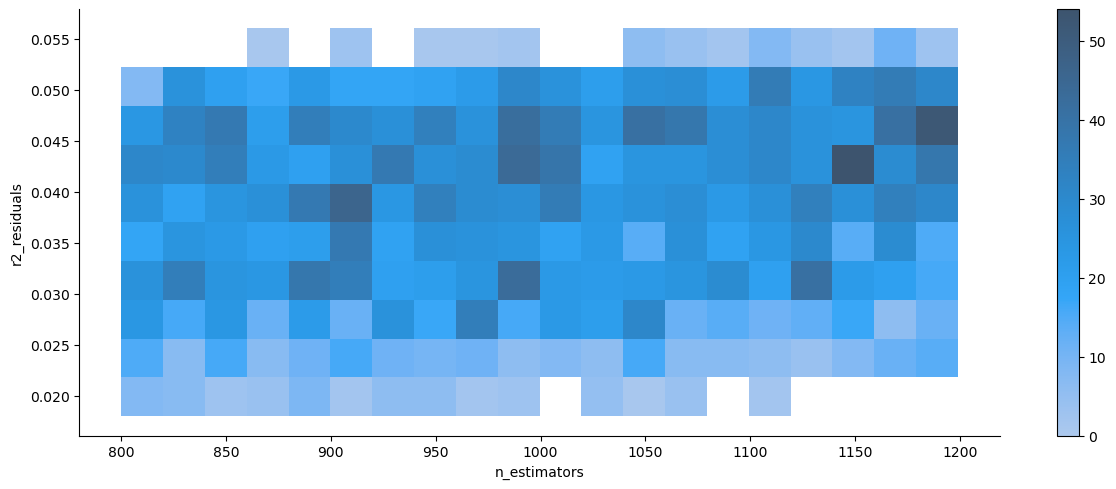

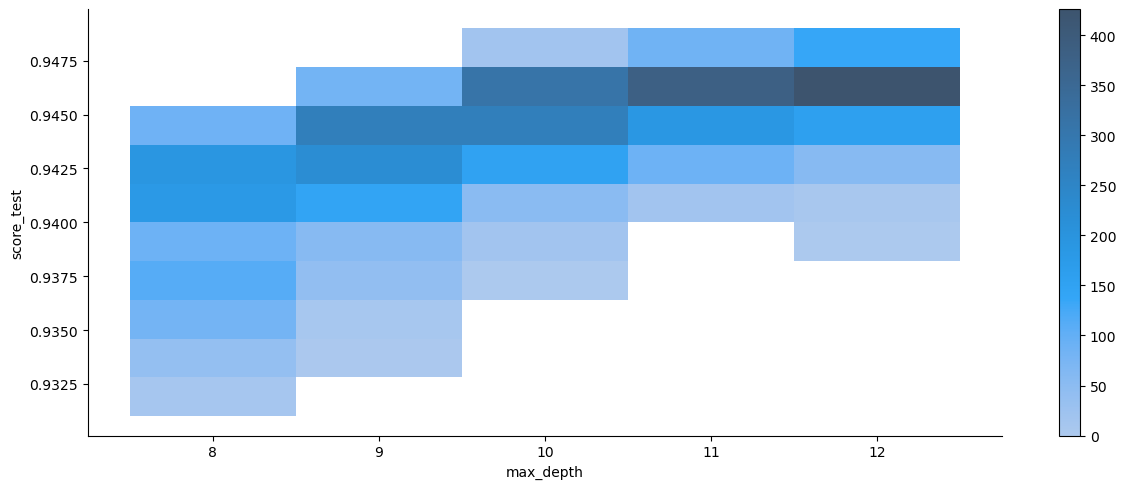

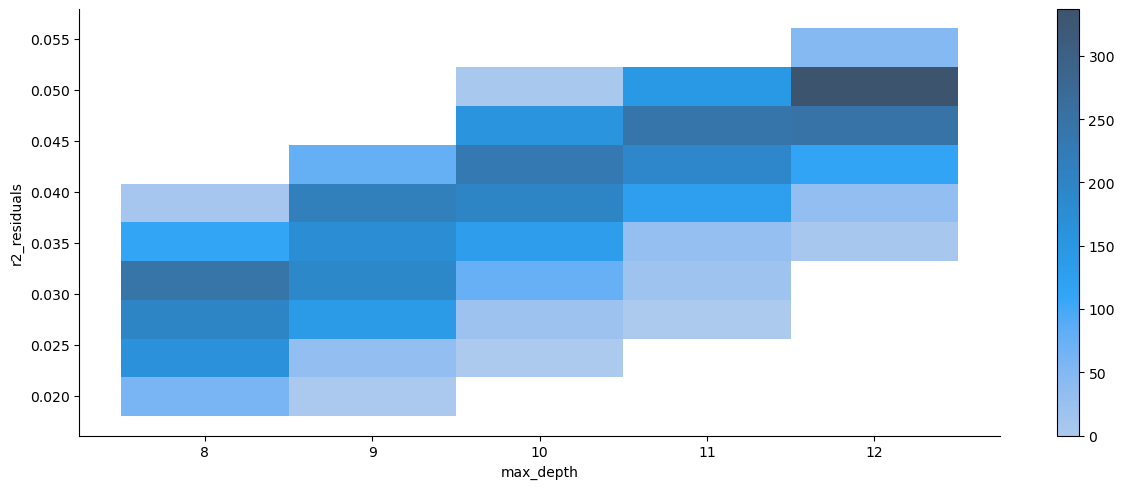

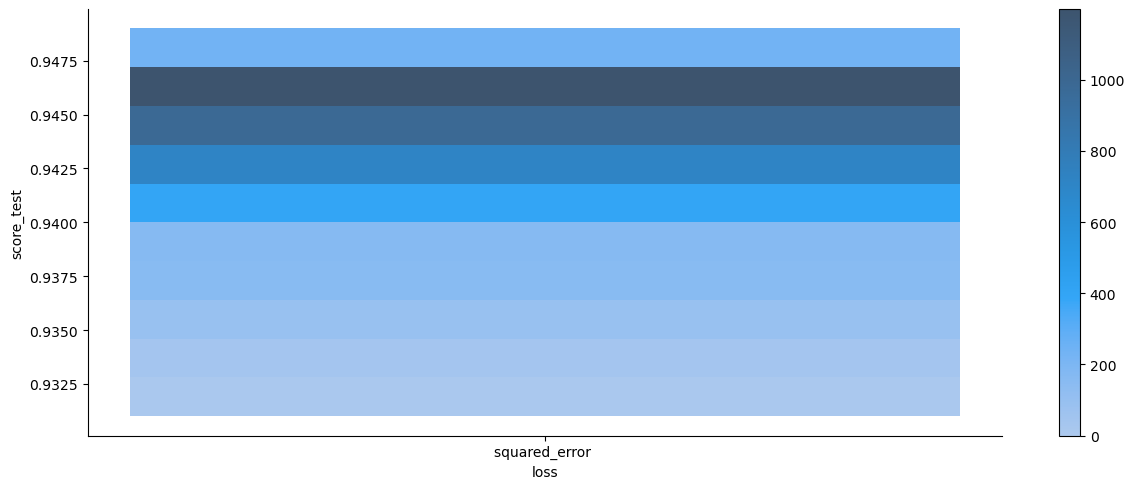

In [12]:
# --- Visualize random search results ---
kwargs = {"discrete": (False, False), "bins": (20, 10), "cbar": True}
sns.displot(
    frame, x="learning_rate", y="score_test", height=5, aspect=2.5, kind="hist", **kwargs
)
plt.show()

sns.displot(
    frame,
    x="learning_rate",
    y="r2_residuals",
    height=5,
    aspect=2.5,
    kind="hist",
    **kwargs
)
plt.show()

sns.displot(
    frame, x="subsample", y="score_test", height=5, aspect=2.5, kind="hist", **kwargs
)
plt.show()

sns.displot(
    frame, x="subsample", y="r2_residuals", height=5, aspect=2.5, kind="hist", **kwargs
)
plt.show()

sns.displot(
    frame, x="n_estimators", y="score_test", height=5, aspect=2.5, kind="hist", **kwargs
)
plt.show()

sns.displot(
    frame, x="n_estimators", y="r2_residuals", height=5, aspect=2.5, kind="hist", **kwargs
)
plt.show()

kwargs = {"discrete": (True, False), "bins": (20, 10), "cbar": True}
sns.displot(
    frame, x="max_depth", y="score_test", height=5, aspect=2.5, kind="hist", **kwargs
)
plt.show()

sns.displot(
    frame, x="max_depth", y="r2_residuals", height=5, aspect=2.5, kind="hist", **kwargs
)
plt.show()

kwargs = {"discrete": (True, False), "bins": (2, 10), "cbar": True}
sns.displot(
    frame, x="loss", y="score_test", height=5, aspect=2.5, kind="hist", **kwargs
)